# EDA ANALISIS

In [1]:
# importamos las librerias que vamos a utilizar

import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.options.display.float_format = '{:.2f}'.format

In [2]:
# cargamos el pickle generado en la notebook de preprocesamiento
# en una variable "df", para trabajar.

with open('NYC_processed.pkl','rb') as p:
    diccionario_pickle = pickle.load(p)
    df = diccionario_pickle['data']
    aux_zonas_decoder = diccionario_pickle['zonas_decoder']
    aux_borough_decoder = diccionario_pickle['borough_decoder']
# # df.head()    
# # df['PUzone'] = df['PUzone'].map(aux_zonas_decoder)
# # df['DOzone'] = df['DOzone'].map(aux_zonas_decoder)

# df['DOborough'] = df['DOborough'].map(aux_borough_decoder)
# df['PUborough'] = df['PUborough'].map(aux_borough_decoder)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200000 entries, 160347 to 2095287
Data columns (total 26 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               1200000 non-null  int8          
 1   tpep_pickup_datetime   1200000 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  1200000 non-null  datetime64[ns]
 3   passenger_count        1200000 non-null  int8          
 4   trip_distance          1200000 non-null  float32       
 5   RatecodeID             1200000 non-null  int8          
 6   store_and_fwd_flag     1200000 non-null  category      
 7   payment_type           1200000 non-null  int8          
 8   fare_amount            1200000 non-null  float16       
 9   extra                  1200000 non-null  float16       
 10  mta_tax                1200000 non-null  float16       
 11  tip_amount             1200000 non-null  float16       
 12  tolls_amount           

In [4]:
# realizamos algunas conversiones de tipos de datos, ya que el metodo .describe(), 
# no interpreta correctamente float16.

colum_float = list(df.columns[8:15])
df['trip_distance']= df.trip_distance.astype('float')
df[colum_float] = df[colum_float].astype('float')

In [5]:
# realizamos un describe para tener una primera mirada de nuestros datos numericos

df.groupby(df.tpep_pickup_datetime.dt.day_name())['total_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
tpep_pickup_datetime,,,,,,,,
Friday,185487.00,16.49,13.06,0.00,8.80,12.30,18.36,215.75
Monday,153276.00,16.29,13.46,0.00,8.75,11.80,17.77,165.38
Saturday,182109.00,15.18,11.48,0.30,8.30,11.76,17.30,231.75
Sunday,158753.00,15.92,12.99,0.00,8.30,11.75,17.80,305.75
Thursday,179938.00,16.75,13.17,0.00,8.80,12.36,18.80,157.00
Tuesday,167407.00,16.22,12.76,0.00,8.80,12.30,17.88,152.38
Wednesday,173030.00,16.41,12.79,0.30,8.80,12.35,18.34,181.75


### Distribucion de cantidad de pasajeros en los viajes en taxi

In [6]:
# observamos como varia la facturacion total de los viajes, respecto a la cantidad de pasajeros.

df.groupby(df.passenger_count).describe(percentiles=list(np.linspace(0.1,1,4)))['total_amount']

,count,mean,std,min,10%,40%,50%,70%,100%,max
passenger_count,,,,,,,,,,
1,927851.00,16.01,12.62,0.00,6.80,10.55,11.80,16.30,231.75,231.75
2,190630.00,16.84,13.62,0.00,6.95,10.80,12.30,16.80,305.75,305.75
3,54760.00,16.49,13.06,0.00,6.85,10.80,12.30,16.62,215.75,215.75
4,26759.00,16.61,13.20,0.30,6.96,10.80,12.30,16.80,176.12,176.12


In [7]:
cant_pasajeros_df = df.groupby('passenger_count').count()['VendorID'].to_frame()
cant_pasajeros_df = cant_pasajeros_df.join(df.passenger_count.value_counts(normalize=True).to_frame().cumsum()*100)

cant_pasajeros_df.columns = ['CANTIDAD DE VIAJES','ACUMULADO PORCENTUAL [%]']

cant_pasajeros_df.index.name = 'CANTIDAD DE PASAJEROS'
cant_pasajeros_df

,CANTIDAD DE VIAJES,ACUMULADO PORCENTUAL [%]
CANTIDAD DE PASAJEROS,,
1,927851,77.32
2,190630,93.21
3,54760,97.77
4,26759,100.00


## ¿CUANTO SE FACTURA EN PROMEDIO POR MES? Y QUE MES ES EL MAS PROVECHOSO?

In [8]:
# Agrupamos por mes a los viajes, y calculamos el promedio facturado 
# y la cantidad de viajes que se realizaron en ese mes

fac_por_mes_df=df.groupby(df.tpep_pickup_datetime.dt.month_name()).agg({'total_amount':'mean','VendorID':'count'})
fac_por_mes_df.columns=['FACTURACION PROMEDIO', 'CANTIDAD DE VIAJES EN EL MES']
fac_por_mes_df.index.name = 'MES'
fac_por_mes_df = fac_por_mes_df.sort_values('FACTURACION PROMEDIO', ascending=False)
fac_por_mes_df

,FACTURACION PROMEDIO,CANTIDAD DE VIAJES EN EL MES
MES,,
September,16.73,100000
June,16.57,100000
May,16.50,100000
November,16.46,100000
October,16.43,100000
July,16.23,100000
August,16.21,100000
December,16.11,100000
April,16.05,100000


In [23]:
fac_por_mes_df['FACTURACION PROMEDIO'].mean()

16.179597552286783

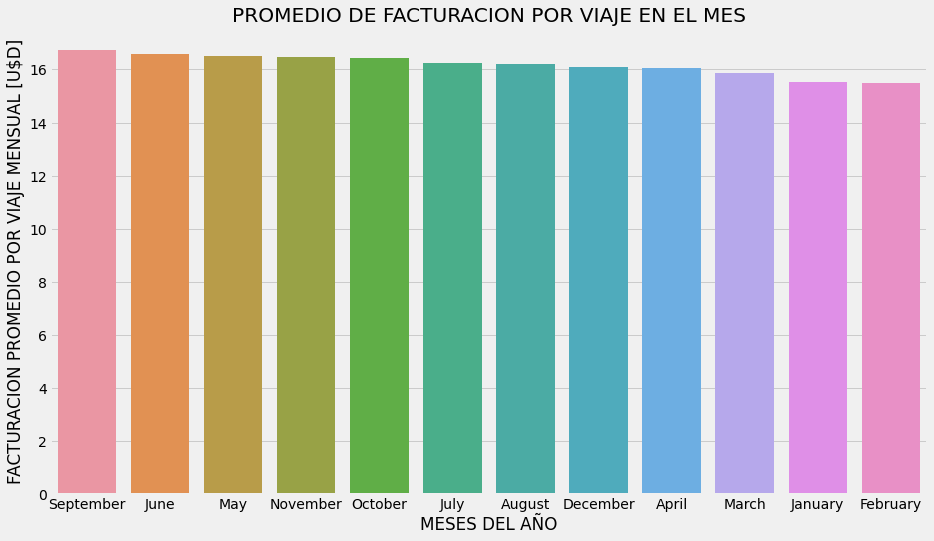

In [9]:
# Realizamos un grafico de barras de la facturacion mensual promedio por viaje

plt.figure(figsize=(14,8))

sns.barplot(data=fac_por_mes_df, x=fac_por_mes_df.index, y= 'FACTURACION PROMEDIO')

plt.title('PROMEDIO DE FACTURACION POR VIAJE EN EL MES')
plt.xlabel('MESES DEL AÑO')
plt.ylabel('FACTURACION PROMEDIO POR VIAJE MENSUAL [U$D]');

#### **Conclusion:** 
##### **El mes mas provechoso para trabajar con el taxi fue junio, con una facturacion promedio por viaje de USD 17,46 por viaje, y siendo el menos provechoso el mes de Diciembre, con una facturacion promedio de USD 16,06 por viaje realizado**

## ¿Cuándo se utilizan más los taxis?, los días laborales o los “días libres”(sábados/domingos)?

In [10]:
# where Monday is 0 and Sunday is 6

df['dia_laborable'] = df.tpep_pickup_datetime.dt.weekday < 5 

# Revisamos la cantidad de viajes que se realizaron los dias laborables
# y los dias no laborables

cant_viajes_dias_lab_y_no_lab=df.dia_laborable.value_counts(normalize = False)
cant_viajes_dias_lab_y_no_lab

True     859138
False    340862
Name: dia_laborable, dtype: int64

In [11]:
# Si ponderamos el resultado, dado que los dias laborales son 2.5 veces mas cantidad de dias

dia_laboral_mayor_dia_no_laboral = cant_viajes_dias_lab_y_no_lab[0] > cant_viajes_dias_lab_y_no_lab[1]*2.5

porc=round(cant_viajes_dias_lab_y_no_lab[1]*2.5/cant_viajes_dias_lab_y_no_lab[0],2)


print('Cantidad ponderada de viajes en dias laborales es mayor que en dias no laborables:\n',dia_laboral_mayor_dia_no_laboral)
print(f'Los taxis se usaron un {porc} % mas en los dias no laborables, al ponderar los valores');

Cantidad ponderada de viajes en dias laborales es mayor que en dias no laborables:
 False
Los taxis se usaron un 6.3 % mas en los dias no laborables, al ponderar los valores


#### **Respuesta: Si bien, al ponderar, vemos que NO hay una gran diferencia en los valores, los taxis se utilizaron en mayor medida los dias NO laborales**

# ¿ Hay alguna correlacion entre las estaciones del año y el uso del taxi?

In [12]:
# Primero tenemos que crear una nueva columna llamada 'season', en donde mapearemos la estacion
# en donde se realizo ese viaje

# SEASONS USA
# Primavera: 21 marzo hasta 20 junio.
# Verano: 21 junio hasta 20 septiembre.
# Otoño: 22 septiembre hasta 21 diciembre.
# Invierno: 22 diciembre hasta 20 marzo.


primavera = df[np.logical_and((df.tpep_pickup_datetime >= datetime(2016, 3, 21)),(df.tpep_pickup_datetime < datetime(2016, 6, 21)))].index
verano = df[np.logical_and((df.tpep_pickup_datetime >= datetime(2016, 6, 21)),(df.tpep_pickup_datetime < datetime(2016, 9, 22)))].index
otonio = df[np.logical_and((df.tpep_pickup_datetime >= datetime(2016, 9, 22)),(df.tpep_pickup_datetime < datetime(2016, 12, 22)))].index
invierno = df[np.logical_and((df.tpep_pickup_datetime >= datetime(2016, 12, 22)),(df.tpep_pickup_datetime <= datetime(2016, 12, 31, hour=23, minute=59, second=59)))].index
invierno_2 = df[np.logical_and((df.tpep_pickup_datetime >= datetime(2016, 1, 1)),(df.tpep_pickup_datetime < datetime(2016, 3, 21)))].index

df.loc[primavera, 'season'] = 'primavera'
df.loc[verano, 'season'] = 'verano'
df.loc[otonio, 'season'] = 'otonio'
df.loc[invierno, 'season'] = 'invierno'
df.loc[invierno_2, 'season'] = 'invierno'

# df.head()

In [13]:
# Agrupamos por estacion del año, y ordenamos de mayor a menor, segun la cantidad de viajes
# que se realizaron en esa estacion. Luego, tambien mostramos la facturacion por viaje de cada mes
# y la distancia que se recorrio en los viajes.

season_df=df.groupby('season').agg({'passenger_count':['count'],
                                 'total_amount':['sum','mean'],
                                 'trip_distance':['max', 'sum']})

season_df.sort_values(('passenger_count','count'), ascending=False)


passenger_count total_amount       trip_distance          
                    count          sum  mean           max       sum
season                                                              
otonio             305572   5031192.93 16.46         49.22 910479.77
primavera          301645   4913367.50 16.29         72.20 912171.28
verano             301475   4933948.94 16.37         47.90 923352.21
invierno           291308   4537007.68 15.57         69.00 852544.26

#### **Conclusion:** 
##### **La estacion en la que mas cantidad de viajes se realizaron fue el otoño.**

## Maratones en New York, ¿Como afectan a la distribución?.

El 6 de noviembre, tuvo lugar la edicion N46 del New York city Marathon https://en.wikipedia.org/wiki/2016_New_York_City_Marathon

In [14]:
maraton_day = pd.to_datetime('2016 11 6')

maraton = df[(df.tpep_pickup_datetime.dt.month == 11) & (df.tpep_pickup_datetime.dt.day == 6)]
# maraton.head(2)

#### Vamos a observar la mediana de la facturacion total por mes y compararla con la del dia del maraton, para ver si el mismo, tuvo algun impacto.

In [15]:
df.groupby(df.tpep_pickup_datetime.dt.month_name()).\
                                    agg({'total_amount':['median','mean','std']})


total_amount            
                           median  mean   std
tpep_pickup_datetime                         
April                       12.05 16.05 12.52
August                      12.10 16.21 12.90
December                    12.25 16.11 12.74
February                    11.75 15.48 12.18
January                     11.75 15.54 12.29
July                        12.25 16.23 12.83
June                        12.30 16.57 13.22
March                       11.80 15.85 12.52
May                         12.30 16.50 13.09
November                    12.30 16.46 13.08
October                     12.30 16.43 13.00
September                   12.35 16.73 13.35

In [16]:
maraton.groupby(maraton.tpep_pickup_datetime.dt.month_name()).agg({'total_amount':['median','mean','std']})

total_amount            
                           median  mean   std
tpep_pickup_datetime                         
November                    11.76 16.51 13.95

#### **Conclusion:** 
##### **El maraton se realizo en el mes de NOVIEMBRE, y vemos resultados de ese dia inferiores a la mediana y media de ese mes, con lo que podriamos concluir que el mismo afecto NEGATIVAMENTE a los viajes en taxi**

## Las elecciones presidenciales del 2016, afectaron de alguna manera el mercado del transporte?

In [17]:
election_day=pd.to_datetime('2016-11-8')


election = df[(df.tpep_pickup_datetime.dt.month==11) & (df.tpep_pickup_datetime.dt.day==8)]
df.groupby(df.tpep_pickup_datetime.dt.month_name()).agg({'total_amount':['median','mean','std']})

total_amount            
                           median  mean   std
tpep_pickup_datetime                         
April                       12.05 16.05 12.52
August                      12.10 16.21 12.90
December                    12.25 16.11 12.74
February                    11.75 15.48 12.18
January                     11.75 15.54 12.29
July                        12.25 16.23 12.83
June                        12.30 16.57 13.22
March                       11.80 15.85 12.52
May                         12.30 16.50 13.09
November                    12.30 16.46 13.08
October                     12.30 16.43 13.00
September                   12.35 16.73 13.35

In [18]:
election.groupby(election.tpep_pickup_datetime.dt.month_name()).agg({'total_amount':['median','mean','std']})

total_amount            
                           median  mean   std
tpep_pickup_datetime                         
November                    11.30 15.14 11.92

#### **Conclusion:** 
##### **Las elecciones presidenciales del 2016, se realizaron en el mes de NOVIEMBRE, y vemos resultados de ese dia inferiores a la mediana y media de ese mes, con lo que podriamos concluir que la misma afecto NEGATIVAMENTE a los viajes en taxi**

# ¿Cuales son las horas de mayor demanda de taxis?

In [19]:
# Agrupamos por hora del dia, y contamos la cantidad de viajes realizados en distintos horarios del dia.

hora_pico_df = df.groupby(df.tpep_pickup_datetime.dt.hour).agg({'VendorID':'count'})

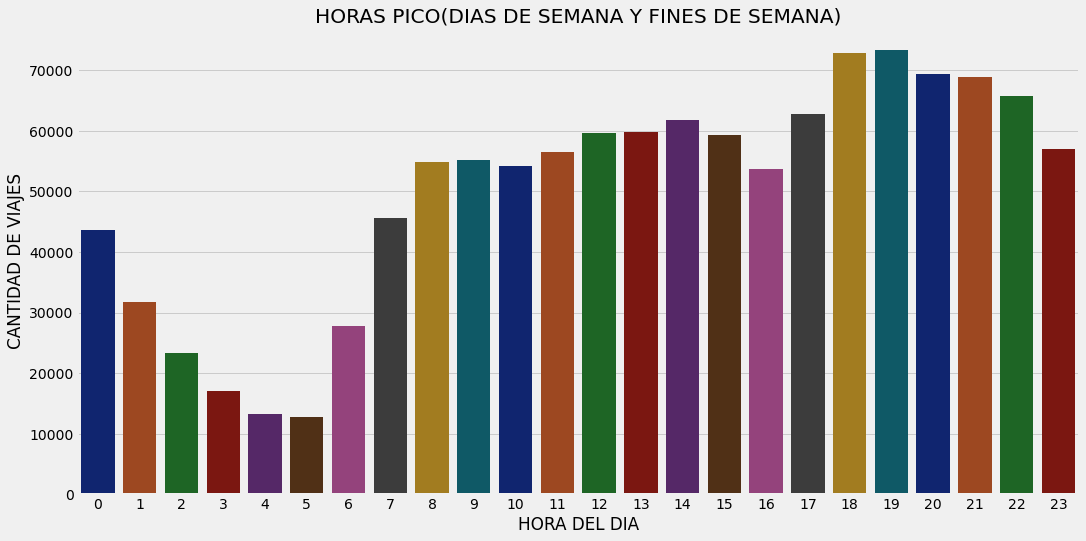

In [20]:
# Graficamos las horas del dia en funcion de la cantidad de viajes realizados, 
# para todos los dias de la semana(Laborables y No Laborables).

plt.figure(figsize=(16,8))

plt.title('HORAS PICO(DIAS DE SEMANA Y FINES DE SEMANA)')
sns.barplot(data = hora_pico_df, x=hora_pico_df.index, y='VendorID', palette='dark')
plt.xlabel('HORA DEL DIA')
plt.ylabel('CANTIDAD DE VIAJES')
plt.show()


**Podemos observar que las horas de mas demanda de taxi son entre las 18h y las 22h, probablemente por la gente que toma un taxi a la salida de su trabajo**

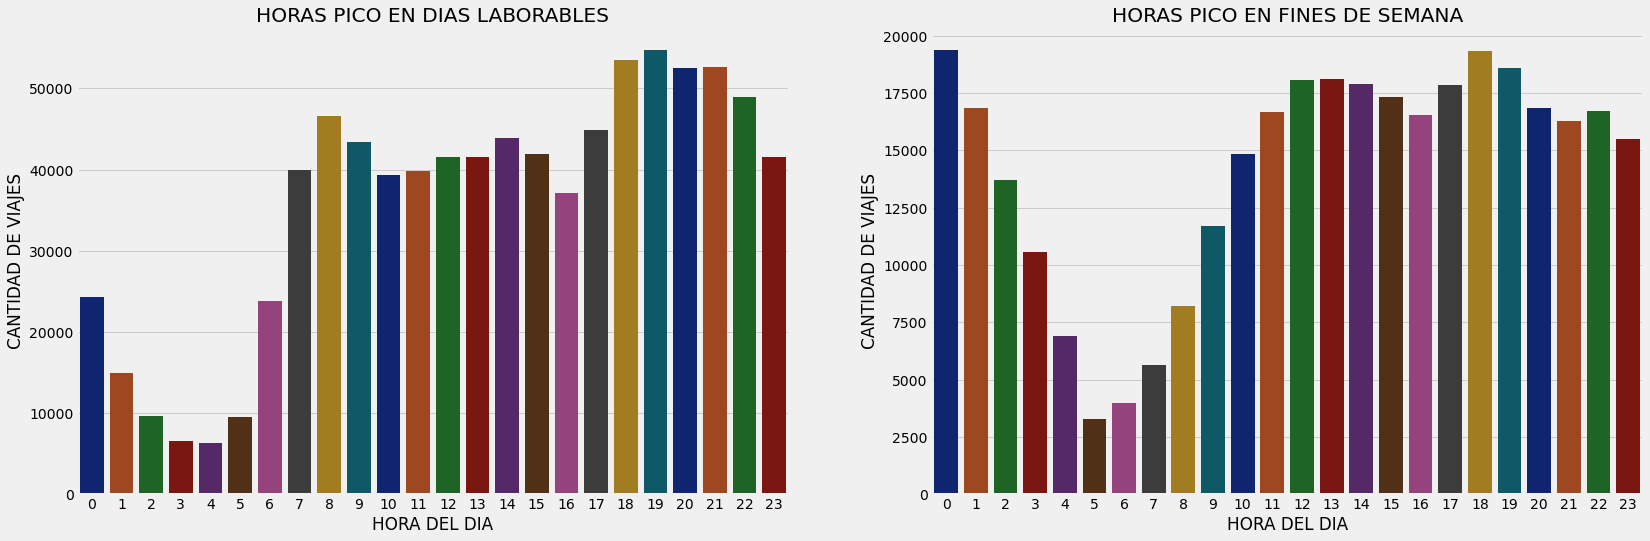

In [21]:
# Graficamos las horas del dia, en funcion de la cantidad de viajes realizados, pero separamos
# en distribucion de dias laborables por un lado y dias no laborables por otro.

fig,axes = plt.subplots(1,2, figsize=(25,8))


hora_pico_laborable_df = df[df.dia_laborable].groupby(df.tpep_pickup_datetime.dt.hour).agg({'VendorID':'count'})


sns.barplot(data = hora_pico_laborable_df, x=hora_pico_laborable_df.index, y='VendorID', palette='dark', ax=axes[0])
axes[0].set_title('HORAS PICO EN DIAS LABORABLES')
axes[0].set_xlabel('HORA DEL DIA')
axes[0].set_ylabel('CANTIDAD DE VIAJES')




hora_pico_no_laborable_df = df[~df.dia_laborable].groupby(df.tpep_pickup_datetime.dt.hour).agg({'VendorID':'count'})

sns.barplot(data = hora_pico_no_laborable_df, x=hora_pico_no_laborable_df.index, y='VendorID', palette='dark', ax=axes[1])
axes[1].set_xlabel('HORA DEL DIA')
axes[1].set_ylabel('CANTIDAD DE VIAJES')
axes[1].set_title('HORAS PICO EN FINES DE SEMANA');

#### **Conclusion:** 
##### Podemos concluir entonces, que las horas de mayor demanda en los `dias de semana`, son entre las 18 y las 22h, y hay un incremento entre las 7 y 8am.
##### Respecto a los `fines de semana`, el pico se origina entre las 00 y la 01h de la madrugada, y se ve otro pico entre las 18 y 19h

# TRABAJEMOS CON LOS DATOS DEL CLIMA

## El dataset Weather, contiene las siguientes variables:

datetime: Fecha y hora del día (EST)

tempm: Temperatura en Celsius

tempi: Temperatura en Fahrenheit

dewptm: Punto de rocío en Celsius

dewpti: punto de rocío en Fahrenheit

zumbido: % de humedad

wspdm: Velocidad del viento en km/h

wspdi: Velocidad del viento en mph

wgustm: Ráfaga de viento en km/h

wgusti: Ráfaga de viento en mph

wdird: dirección del viento en grados

wdire: descripción de la dirección del viento

vism: Vivibilidad en Km

visi: Visibilidad en millas

presiónm: Presión en mBar

pressurei: Presión en inHg

windchillm: sensación térmica en Celcius

windchilli: sensación térmica en Fahrenheit

heatindexm: índice de calor Celcius

heatindexi: índice de calor Fahrenheit

precipm: Precipitación en mm

precipi: Precipitación en pulgadas

conds: Condiciones: Ver lista completa de condiciones

niebla: booleano

lluvia: booleano

nieve: booleano

granizo: booleano

trueno: booleano

tornado: booleano

In [22]:
weather = pd.read_csv('weather.csv', parse_dates=['pickup_datetime'])
weather.head(3)

FileNotFoundError: [Errno 2] No such file or directory: 'weather.csv'

In [ ]:
weather.shape

In [ ]:
weather.info()

In [ ]:
# Reparacion del dataset weather
# Utilizamos una solucion que propuso un usuario de kaggle a un error que tenia este dataset
# https://www.kaggle.com/code/srcole/original-datetime-is-broken-month-and-day-mixed/notebook

# Switch month and day when day is less than 12
weather['date'] = pd.to_datetime(weather['pickup_datetime'])
weather['month'] = weather['date'].dt.month
weather['year'] = weather['date'].dt.year
weather['day'] = weather['date'].dt.day
weather['hour'] = weather['date'].dt.hour
weather['minute'] = weather['date'].dt.minute

def compute_right_day(row):
    if row['day'] <= 12:
        return row['month']
    else:
        return row['day']

def compute_right_month(row):
    if row['day'] <= 12:
        return row['day']
    else:
        return row['month']

def compute_right_date(row):
    return '{:d}-{:d}-{:d} {:d}:{:d}'.format(row['year'], row['new_month'], row['new_day'],
                                             row['hour'], row['minute'])

weather['new_day'] = weather.apply(compute_right_day, axis=1)
weather['new_month'] = weather.apply(compute_right_month, axis=1)
weather['new_date_str'] = weather.apply(compute_right_date, axis=1)
weather['date'] = pd.to_datetime(weather['new_date_str'])
weather = weather[['date', 'tempm','rain','snow']]
# weather.set_index('date', inplace=True)
weather.sort_index(inplace=True)

In [ ]:
weather.head()

In [ ]:
weather.info()

In [ ]:
# vamos a filtrar solo el año 2016, que es lo que nos interesa.

weather = weather[weather['date'].dt.year==2016].reset_index(drop=True)

In [ ]:
weather.head()

In [ ]:
# Vamos a crear nuevas columnas en el dataset, que posteriormente nos ayudaran a unir
# las fechas con nuestro dataset de taxis.

weather['fecha_sin_hora']=weather.date.apply(lambda x: str(x).split(' ')[0])
weather['dia']=weather.fecha_sin_hora.apply(lambda x: str(x).split('-')[2])
weather['mes']=weather.fecha_sin_hora.apply(lambda x: str(x).split('-')[1])

In [ ]:
# Me creo una lista con los dias que llovio y nevo en NYC, para dsp trackearlos en mi dataframe "df"

dias_nieve_list=weather[weather.snow ==1]['fecha_sin_hora'].to_list()
dias_lluvia_list=weather[weather.rain ==1]['fecha_sin_hora'].to_list()

In [ ]:
df['pickup_sin_hora'] = df.tpep_pickup_datetime.apply(lambda x: str(x).split(' ')[0])

In [ ]:
def llueve(dia):
    '''Funcion que pone True si ese dia se registro lluvia en NY,
    a partir de una lista generada con el dataset weather'''
    for llueve in dias_lluvia_list:
        if dia == llueve:
            return True
        else:
            return False
        
def nevar(dia):
    '''Funcion que pone True si ese dia se registro nieve en NY,
    a partir de una lista generada con el dataset weather'''
    for nieva in dias_nieve_list:
        if dia == nieva:
            return True
        else:
            return False
    
    
    
df['lluvia']= df.pickup_sin_hora.apply(lambda x:llueve(x))
df['nieva']= df.pickup_sin_hora.apply(lambda x:nevar(x))


## Como afectaron los dias lluviosos a los taxis?

In [ ]:
df.groupby(['lluvia']).agg({'total_amount':['mean','std'],
                                   'trip_distance':['mean','std'],
                                   'passenger_count':['mean','std'],
                                   'VendorID':['count']})


#### **Conclusion:** 
##### Los dias de lluvia, no modifican en gran medida el uso de los taxis amarillos.


## Como afecto la nieve a los taxis?

In [ ]:
df.groupby(['nieva']).agg({'total_amount':['mean','std'],
                                   'trip_distance':['mean','std'],
                                   'passenger_count':['mean','std']})

#### **Conclusion:** 
##### Los dias que nevo, se observa una facturacion promedio inferior a los demas dias. Por lo que la nieve afecta NEGATIVAMENTE al rubro

In [ ]:
# Debido a que tenemos varias temperaturas en distintos horarios para el mismo dia
# vamos a obtener la mediana de la temperatura por dia y mes del año, y luego lo vamos a mergear al dataframe de taxis.

temp_df = weather.groupby(['mes','dia']).agg({'tempm':'median'})
temp_df = temp_df.reset_index()

# Creamos una columna nueva en el dataset de weather para utilizarla para mergear
temp_df['mes-dia']=temp_df['mes']+temp_df['dia']
# temp_df

# Creamos una columna nueva en el dataset de taxis para utilizarla para mergear
df['mes-dia']=df.pickup_sin_hora.apply(lambda x: x.split('-')[1]+x.split('-')[2])


In [ ]:
df = df.merge(temp_df, on='mes-dia')
df = df.drop(['mes-dia'], axis=1) # droppeamos la columna de mergeo, ya que no la utilizamos mas
df.head()

In [ ]:
df.groupby('season').agg({'total_amount':'mean',
                          'tempm':['median'],
                          'tempm':['count','median']}).sort_values(('tempm','count')
                                                                   , ascending = False)

Observamos si hay alguna correlacion entre la temperatura del dia y la forma de uso del taxi


In [ ]:
corelaciones_con_temp_df = df.corr(method='spearman')['tempm'].drop('tempm').sort_values().to_frame()
corelaciones_con_temp_df

In [ ]:
# Observamos valores realmente muy bajos, salvo con "INTRAZONE_TRIP"

corr_temp_df=abs(df.corr(method='spearman')['tempm'].drop('tempm')).sort_values(ascending=False)[:5]

plt.figure(figsize=(20,8))
sns.barplot(data=corr_temp_df, x=corr_temp_df.index, y=corr_temp_df)
plt.title('CORRELACION ABSOLUTA ENTRE LA MEDIANA DIARIA DE TEMPERATURA Y EL RESTO DE LAS VARIABLES')
plt.ylabel('GRADO DE CORRELACION ABSOLUTA')
plt.xticks(np.linspace(0,4,5),labels=list(corr_temp_df.index.values)[::-1]);

No observamos una gran correlacion entre la temperatura y alguna de las variables del dataset, salvo con INTRAZONE_TRIP, que posee una correlacion de spearman **negativa** del orden del 18% (al aumentar la temperatura, disminuyen la cantidad de viajes que son en la misma zona), pero no podemos asegurar que tenga una correlacion con la distancia del viaje, debido a los valores bajos de correlacion con ésta ultima.